<a href="https://colab.research.google.com/github/rnop/nmr_tournament/blob/main/introduction_legacy_dataset.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Important note**: This notebook is specifically for the old legacy Numerai dataset. Numerai has told us the API for the legacy dataset will be depracated within 6 months from release of the new dataset (released in September 2021). I plan on moving to the new dataset ASAP and discontinuing use of the old legacy data. Therefore, this notebook will no longer be updated and may not work in the future. 

### Introduction to the Numerai Tournament
Numerai is a hedge fund that trades the global markets based on models created by data scientists all over the world. Numerai is unique in that it provides free high-quality financial datasets that are worth millions of dollars to any user wanting to participate in their tournament. Users are able to build their own models on this anonymized and obfuscated dataset, submit their predictions, and follow their investment performance on the live stock market. If users are confident about their models, they are able to stake on them with real money using Numerai's cryptocurrency, Numeraire (NMR).

### About this Notebook
The purpose of this notebook is to provide an introduction on how to approach the main Numerai tournament. Alot of the code is taken from example scripts from Numerai's official GitHub here: https://github.com/numerai/example-scripts

What's included:
* how to read in the Numerai data via API
* approaches to dimensionality reduction
* training an xgboost model 
* bayesian optimization techniques
* calculating predictions from the current round

### Disclaimer
**This model is not guaranteed to make you money.** I am currently not staking this particular model in the tournament. This notebook only serves to provide you an introduction to the tournament and to give some of my personal input on how to tackle this data science problem. 

In [1]:
# Download the numerai library 
! pip install numerapi

In [34]:
import pandas as pd
import numpy as np
import numerapi

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_style('darkgrid')

### Import data
* Training data contains 501,808 observations
* Tournament data contains the testing and validation sets, and the live observations you need to predict on for the upcoming round

In [3]:
host = 'numerai-public-datasets.s3-us-west-2.amazonaws.com'
train_filename = 'latest_numerai_training_data.csv.xz'
tourney_filename = 'latest_numerai_tournament_data.csv.xz'

train_df = pd.read_csv('https://{}/{}'.format(host, train_filename))
tourney_df = pd.read_csv('https://{}/{}'.format(host, tourney_filename))

#Confirm round number
napi = numerapi.NumerAPI(verbosity="info")
current_round = napi.get_current_round()
print()
print("ROUND NUMBER: ", current_round)


ROUND NUMBER:  282


In [4]:
train_df.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n000315175b67977,era1,train,0.00,0.50,0.25,0.00,0.5,0.25,0.25,0.25,0.75,0.75,0.25,0.25,1.00,0.75,0.5,1.0,0.5,0.00,0.50,0.50,0.00,0.0,0.00,1.00,0.25,0.00,0.50,0.25,0.75,0.50,1.00,0.75,0.75,0.5,0.50,0.75,0.5,...,0.75,0.75,0.75,0.50,1.00,1.00,0.50,0.75,0.5,0.25,0.25,0.75,0.50,1.00,0.5,0.75,0.75,0.25,0.50,1.00,0.75,0.50,0.50,1.00,0.25,0.5,0.50,0.50,0.75,1.00,1.00,1.00,0.75,0.50,0.75,0.50,1.00,0.50,0.75,0.50
1,n0014af834a96cdd,era1,train,0.00,0.00,0.00,0.25,0.5,0.00,0.00,0.25,0.50,0.50,0.00,0.50,0.00,0.50,0.5,0.5,0.5,0.50,0.25,0.25,0.50,0.0,1.00,0.50,0.50,0.50,0.75,0.50,0.50,0.75,0.25,0.50,0.75,0.5,0.25,0.75,0.5,...,0.25,0.25,0.25,1.00,1.00,0.50,0.50,0.50,0.0,0.25,1.00,0.50,1.00,1.00,0.5,0.50,0.50,1.00,0.25,0.75,1.00,0.25,0.25,1.00,0.50,0.5,0.50,0.75,0.75,0.75,1.00,1.00,0.00,0.00,0.75,0.25,0.00,0.25,1.00,0.25
2,n001c93979ac41d4,era1,train,0.25,0.50,0.25,0.25,1.0,0.75,0.75,0.25,0.00,0.25,0.50,1.00,0.50,0.75,0.5,0.5,1.0,0.50,0.50,0.50,0.25,0.0,0.25,0.75,0.75,0.75,0.50,0.75,0.50,0.25,0.50,0.75,0.25,0.5,0.50,0.75,0.5,...,0.25,1.00,1.00,1.00,0.50,1.00,1.00,1.00,0.5,1.00,0.00,1.00,1.00,0.50,1.0,0.75,1.00,0.00,0.50,0.75,0.00,1.00,0.50,0.50,0.75,1.0,0.75,1.00,0.25,0.50,0.25,0.50,0.00,0.00,0.50,1.00,0.00,0.25,0.75,0.25
3,n0034e4143f22a13,era1,train,1.00,0.00,0.00,0.50,0.5,0.25,0.25,0.75,0.25,0.50,0.50,0.50,0.75,0.50,1.0,0.5,0.5,0.00,1.00,0.00,0.75,0.0,0.50,0.50,0.50,0.50,0.00,0.50,0.50,0.75,0.75,0.50,0.25,0.5,0.50,0.50,0.5,...,1.00,1.00,0.75,0.75,1.00,0.75,0.75,0.75,1.0,0.75,1.00,0.75,1.00,0.75,1.0,0.00,0.50,0.75,1.00,0.75,1.00,0.75,1.00,1.00,0.00,0.5,0.75,0.75,1.00,0.75,1.00,1.00,0.75,0.75,1.00,1.00,0.75,1.00,1.00,0.25
4,n00679d1a636062f,era1,train,0.25,0.25,0.25,0.25,0.0,0.25,0.50,0.25,0.25,0.50,0.25,0.25,0.75,0.50,0.0,0.5,0.5,0.25,0.00,0.50,0.00,0.5,0.25,0.50,0.50,0.50,0.50,0.50,0.50,0.50,0.75,0.50,0.25,0.5,0.50,0.50,0.5,...,1.00,0.25,0.75,1.00,0.75,0.00,0.00,0.75,0.5,1.00,0.50,0.75,0.25,0.50,0.0,0.50,0.50,0.50,0.75,0.75,0.50,0.75,0.25,0.75,0.50,0.5,0.25,0.25,0.75,0.50,0.75,0.75,0.25,0.50,0.75,0.00,0.50,0.25,0.75,0.75


In [5]:
tourney_df.head()

,id,era,data_type,feature_intelligence1,feature_intelligence2,feature_intelligence3,feature_intelligence4,feature_intelligence5,feature_intelligence6,feature_intelligence7,feature_intelligence8,feature_intelligence9,feature_intelligence10,feature_intelligence11,feature_intelligence12,feature_charisma1,feature_charisma2,feature_charisma3,feature_charisma4,feature_charisma5,feature_charisma6,feature_charisma7,feature_charisma8,feature_charisma9,feature_charisma10,feature_charisma11,feature_charisma12,feature_charisma13,feature_charisma14,feature_charisma15,feature_charisma16,feature_charisma17,feature_charisma18,feature_charisma19,feature_charisma20,feature_charisma21,feature_charisma22,feature_charisma23,feature_charisma24,feature_charisma25,...,feature_wisdom8,feature_wisdom9,feature_wisdom10,feature_wisdom11,feature_wisdom12,feature_wisdom13,feature_wisdom14,feature_wisdom15,feature_wisdom16,feature_wisdom17,feature_wisdom18,feature_wisdom19,feature_wisdom20,feature_wisdom21,feature_wisdom22,feature_wisdom23,feature_wisdom24,feature_wisdom25,feature_wisdom26,feature_wisdom27,feature_wisdom28,feature_wisdom29,feature_wisdom30,feature_wisdom31,feature_wisdom32,feature_wisdom33,feature_wisdom34,feature_wisdom35,feature_wisdom36,feature_wisdom37,feature_wisdom38,feature_wisdom39,feature_wisdom40,feature_wisdom41,feature_wisdom42,feature_wisdom43,feature_wisdom44,feature_wisdom45,feature_wisdom46,target
0,n0003aa52cab36c2,era121,validation,0.25,0.75,0.50,0.50,0.0,0.75,0.5,0.25,0.50,0.5,0.25,0.0,0.25,0.50,0.25,0.00,0.25,1.00,1.00,0.25,1.00,1.00,0.25,0.25,0.0,0.50,0.25,0.75,0.00,0.50,0.25,0.25,0.25,0.50,0.00,0.50,1.00,...,0.00,0.0,0.25,0.5,0.25,0.25,0.00,0.25,0.00,0.25,0.50,0.50,0.50,0.50,0.00,0.25,0.75,0.25,0.25,0.50,0.25,0.00,0.25,0.50,0.25,0.5,0.25,0.25,1.00,0.75,0.75,0.75,1.00,0.75,0.50,0.5,1.0,0.00,0.00,0.25
1,n000920ed083903f,era121,validation,0.75,0.50,0.75,1.00,0.5,0.00,0.0,0.75,0.25,0.0,0.75,0.5,0.00,0.25,0.50,0.00,1.00,0.25,0.25,1.00,1.00,0.25,0.75,0.00,0.0,0.75,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.25,0.00,1.00,...,0.50,0.5,0.25,1.0,0.50,0.25,0.00,0.25,0.50,0.25,1.00,0.25,0.00,0.50,0.75,0.75,0.50,1.00,1.00,0.25,0.50,0.25,0.50,0.50,0.50,0.5,0.25,0.25,0.75,0.50,0.50,0.50,0.75,1.00,0.75,0.5,0.5,0.50,0.50,0.50
2,n0038e640522c4a6,era121,validation,1.00,0.00,0.00,1.00,1.0,1.00,1.0,1.00,0.50,0.5,1.00,1.0,1.00,0.75,0.50,0.50,1.00,1.00,0.50,0.50,0.00,1.00,0.50,1.00,0.5,1.00,0.50,1.00,0.25,1.00,1.00,1.00,0.50,1.00,1.00,0.75,1.00,...,0.25,0.5,0.00,0.0,0.00,0.25,0.25,0.00,0.50,0.00,0.00,0.00,0.25,0.00,0.25,0.50,0.00,0.00,0.00,0.00,0.00,0.00,0.50,0.00,0.75,0.0,0.00,0.25,0.00,0.00,0.00,0.00,0.50,0.25,0.00,0.0,0.5,0.50,0.00,1.00
3,n004ac94a87dc54b,era121,validation,0.75,1.00,1.00,0.50,0.0,0.00,0.0,0.50,0.75,1.0,0.75,0.0,0.50,0.00,0.50,0.75,0.50,0.75,0.25,0.75,0.25,0.75,0.25,0.75,1.0,0.50,0.50,0.75,0.50,1.00,0.50,0.25,0.75,0.25,0.75,0.25,0.75,...,0.00,0.0,0.00,0.0,0.00,0.00,0.00,0.00,0.25,0.00,0.25,0.00,0.00,0.25,0.00,0.00,0.00,0.00,0.75,0.00,0.00,0.25,0.25,0.00,0.00,0.0,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.25,0.00,0.0,0.0,0.25,0.25,0.50
4,n0052fe97ea0c05f,era121,validation,0.25,0.50,0.50,0.25,1.0,0.50,0.5,0.25,0.25,0.5,0.50,1.0,1.00,1.00,1.00,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.00,0.25,0.0,0.00,0.75,0.25,1.00,0.25,1.00,0.75,0.00,1.00,0.75,0.75,0.75,...,0.00,0.5,0.50,0.0,0.75,0.50,0.75,0.25,0.25,0.25,0.00,0.25,0.50,0.25,1.00,1.00,1.00,0.00,0.25,0.00,0.00,0.25,0.25,0.75,1.00,1.0,0.75,0.75,0.50,0.50,0.50,0.75,0.00,0.00,0.75,1.0,0.0,0.25,1.00,0.75


In [6]:
# Number of observations in each dataset type
tourney_df['data_type'].value_counts()

test          1673853
validation     137779
live             5339
Name: data_type, dtype: int64

### Data Preprocessing
Most of the data cleaning has been done by Numerai in order to anonymize and obfuscate the data to us. This is done purposefully because of the data sharing rights from the data vendors Numerai spends millions of dollars on (thank you Numerai!). 

Steps:
* Extract features
* Convert era from string to integers

In [7]:
# Extract features
tourney_ids = tourney_df['id']
features = [c for c in tourney_df if c.startswith('feature')]

# The training data is also grouped into 120 different eras (1-120)
train_df["erano"] = train_df["era"].str.slice(3).astype(int)

valid_df = tourney_df[tourney_df['data_type']=='validation']
valid_df["erano"] = valid_df["era"].str.slice(3).astype(int)

# Extract eras
eras = train_df["erano"]
target = "target"

print("Training:", train_df.shape)
print("Validation:", valid_df.shape)
print("Tournament:", tourney_df.shape)

Training: (501808, 315)
Validation: (137779, 315)
Tournament: (1816971, 314)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


In [8]:
print("First five features:")
print(features[:5])
print()
print("Number of unique eras in training data: ", len(set(eras)))

First five features:
['feature_intelligence1', 'feature_intelligence2', 'feature_intelligence3', 'feature_intelligence4', 'feature_intelligence5']

Number of unique eras in training data:  120


### Split the training data into training/testing sets
Things to think about:
* Is it useful to use all of the features?
* How should we think about the different eras in the data?
* Do some features matter more in particular eras than in other eras?

In [9]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(train_df[features], train_df[target],
                                                    test_size=0.25, random_state=0)

print("X_train size: ", X_train.shape)
print("X_test_size: ", X_test.shape)

X_train size:  (376356, 310)
X_test_size:  (125452, 310)


### Dimensionality Reduction Techniques
The original dataset has 310 features so it might be useful to reduce the number of features. Here I will implement the following dimension reduction techniques:
* PCA
* K-Means Clustering

PCA
* You can change the number of components or % variance retained

In [10]:
from sklearn.decomposition import PCA

# You can specify the number of components
pca = PCA(n_components=120)
pca_train = pca.fit_transform(X_train)
explained_variance = pca.explained_variance_ratio_
print(np.cumsum(explained_variance))

[0.10420083 0.18434788 0.23781185 0.27809144 0.31211651 0.34185984
 0.36638192 0.38865699 0.40826849 0.42644541 0.44202931 0.45648403
 0.46998241 0.48279143 0.49494177 0.50692192 0.51838483 0.5293772
 0.54021484 0.55043026 0.56035963 0.57011853 0.57947186 0.58864781
 0.59747686 0.60579155 0.61383015 0.62180926 0.6294822  0.6369286
 0.64428767 0.65146668 0.65836098 0.66518295 0.67180242 0.67836877
 0.68466644 0.69086353 0.69690065 0.70276687 0.70850262 0.71413115
 0.71965471 0.72507904 0.73038159 0.73555206 0.74058999 0.74546826
 0.75023816 0.75497613 0.7596351  0.76420083 0.76869342 0.77315534
 0.77747269 0.78173191 0.78592465 0.79006857 0.79408329 0.79808812
 0.80202668 0.80588438 0.80965372 0.81335564 0.81699492 0.82057578
 0.82404156 0.82747084 0.83087083 0.83419201 0.83745961 0.84072442
 0.84393032 0.84710122 0.85022976 0.85324735 0.85624415 0.85916367
 0.86201914 0.86478882 0.86752555 0.87022047 0.87284895 0.87545629
 0.87804583 0.88059173 0.88307621 0.88551705 0.88792876 0.890275

In [11]:
# You could also specify the % of variance you want to retain
pca = PCA(n_components=0.90) #specify 90% retention 
pca_train = pca.fit_transform(X_train)

# Explained variance of each component
explained_variance = pca.explained_variance_ratio_
print("Number of components with % variance: ", len(explained_variance))
print(np.cumsum(explained_variance))

Number of components with % variance:  95
[0.10420083 0.18434788 0.23781185 0.27809144 0.31211651 0.34185984
 0.36638192 0.38865699 0.40826849 0.42644541 0.44202931 0.45648403
 0.46998241 0.48279143 0.49494177 0.50692192 0.51838483 0.5293772
 0.54021484 0.55043026 0.56035963 0.57011853 0.57947186 0.58864781
 0.59747686 0.60579155 0.61383015 0.62180926 0.6294822  0.6369286
 0.64428767 0.65146668 0.65836099 0.66518296 0.67180242 0.67836877
 0.68466644 0.69086353 0.69690065 0.70276688 0.70850262 0.71413116
 0.71965472 0.72507905 0.73038159 0.73555206 0.74059    0.74546827
 0.75023817 0.75497615 0.75963511 0.76420085 0.76869344 0.77315537
 0.77747272 0.78173194 0.7859247  0.79006862 0.79408334 0.79808818
 0.80202674 0.80588445 0.80965381 0.81335573 0.81699503 0.82057589
 0.8240417  0.82747103 0.83087104 0.83419225 0.83745992 0.84072477
 0.84393068 0.84710162 0.85023017 0.85324781 0.8562447  0.85916427
 0.86201979 0.86478959 0.86752645 0.87022146 0.87285012 0.87545754
 0.87804736 0.88059364

In [12]:
print("Original X_train shape:", X_train.shape)
print("PCA Transformed X_train shape:", pca_train.shape)

Original X_train shape: (376356, 310)
PCA Transformed X_train shape: (376356, 95)


K-Means Clustering
* You can change the number of clusters

In [13]:
from sklearn.cluster import KMeans, MiniBatchKMeans

# Reduce to 120 clusters
kmeans120 = MiniBatchKMeans(n_clusters=120, random_state=6).fit(X_train)
kmeans120_train = kmeans120.transform(X_train)

In [14]:
print("Original X_train shape:", X_train.shape)
print("K-Means Clustered X_train shape:", kmeans120_train.shape)

Original X_train shape: (376356, 310)
K-Means Clustered X_train shape: (376356, 120)


### Bayesian Optimization for xgboost
Documentation: https://github.com/fmfn/BayesianOptimization
* I am going to use the PCA transformed training data but you can easily switch it to PCA or K-means clustering
* set 'tree_method':'gpu_hist' to train on GPU for faster training

In [15]:
# Download bayesian-optimization library
! pip install bayesian-optimization

  Created wheel for bayesian-optimization: filename=bayesian_optimization-1.2.0-py3-none-any.whl size=11685 sha256=d41aa970abdd2a7048774c627ee748bbbde5cc0c970303fc1b799b8af7d47d8e
  Stored in directory: /root/.cache/pip/wheels/fd/9b/71/f127d694e02eb40bcf18c7ae9613b88a6be4470f57a8528c5b
Successfully built bayesian-optimization


In [17]:
import xgboost
from bayes_opt import BayesianOptimization

# Convert pca transformed training data to DMatrix for XGBoost
dtrain = xgboost.DMatrix(pca_train, y_train)
 
def bo_tune_xgb(max_depth, gamma, learning_rate, subsample, colsample_bytree, min_child_weight, n_estimators, alpha, eta):
    params = {'max_depth': int(max_depth),
              'gamma': gamma,
              'learning_rate': learning_rate,
              'subsample': subsample,
              'colsample_bytree': colsample_bytree,
              'min_child_weight': min_child_weight,
              'n_estimators': int(n_estimators),
              'alpha': alpha,
              'eta': eta,
              'eval_metric': 'rmse',
             # 'tree_method': 'gpu_hist' # If using GPU
    }
    #Cross validating with the specified parameters in 3 folds
    cv_result = xgboost.cv(params, dtrain, nfold=3)
    #Return the negative RMSE
    return -1.0 * cv_result['test-rmse-mean'].iloc[-1]

#### n_iter 
* controls how many bayesian optimization steps to perform, more steps = more likely to find a good maximization

#### init_points 
* controls how many steps of random exploration you want to perform to help diversify the exploration space

#### acquisition functions
* decides how to guide the optimization
* acq: {'ucb', 'ei', 'poi'}

In [18]:
# Initial Bayesian Optimization Search
xgb_bo = BayesianOptimization(bo_tune_xgb, {'max_depth': (4,12),
                                             'gamma': (0.1, 1),
                                             'subsample' : (0.5, 1),
                                             'learning_rate' : (0.0001, 0.01),
                                             'colsample_bytree': (0.7, 1),
                                             'min_child_weight': (4, 10),
                                             'n_estimators':(80, 240),
                                             'alpha': (0.1, 1),
                                             'eta': (0.1, 0.3)
                                            })

xgb_bo.maximize(n_iter=5, init_points=5, acq='ei')

|   iter    |  target   |   alpha   | colsam... |    eta    |   gamma   | learni... | max_depth | min_ch... | n_esti... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------
|  1        | -0.2235   |  0.6713   |  0.9552   |  0.1488   |  0.389    |  0.001945 |  4.895    |  4.141    |  205.5    |  0.7555   |
|  2        | -0.2235   |  0.5646   |  0.8184   |  0.1965   |  0.1735   |  0.005396 |  9.82     |  9.953    |  84.7     |  0.5575   |
|  3        | -0.2235   |  0.3851   |  0.7836   |  0.2771   |  0.3727   |  0.004567 |  11.13    |  5.588    |  228.0    |  0.5664   |
|  4        | -0.2235   |  0.2464   |  0.8044   |  0.233    |  0.2049   |  0.009054 |  6.255    |  8.016    |  206.9    |  0.7401   |
|  5        | -0.2235   |  0.3867   |  0.787    |  0.2056   |  0.7921   |  0.005719 |  4.485    |  6.337    |  185.2    |  0.9031   |
|  6        | -0.2235   |  0.3262   |  0.9556   |  0.2585   | 

Just for this notebook I kept the number of iterations and initiation points relatively small so it doesn't a long time to run.

In [19]:
# Obtain best parameters from bayesian optimization search
params = xgb_bo.max['params']

#Converting the max_depth and n_estimator values from float to int
params['max_depth']= int(round(params['max_depth']))
params['n_estimators']= int(round(params['n_estimators']))
params

{'alpha': 0.24642989881163418,
 'colsample_bytree': 0.8044273945251768,
 'eta': 0.23298800735571254,
 'gamma': 0.20489379828423035,
 'learning_rate': 0.009054435155224298,
 'max_depth': 6,
 'min_child_weight': 8.01631989179294,
 'n_estimators': 207,
 'subsample': 0.7400815874542308}

In [21]:
#Re-train XGBRegressor with best params found from bayesian optimization
pca_X_train = pca.transform(X_train)
xgb_bestparams = xgboost.XGBRegressor(**params).fit(pca_X_train, y_train)

[15:59:10] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


### Model Evaluation

In [30]:
# The models should be scored based on the rank-correlation (spearman) with the target
def numerai_score(y_true, y_pred):
    rank_pred = y_pred.groupby(eras).apply(lambda x: x.rank(pct=True, method="first"))
    return np.corrcoef(y_true, rank_pred)[0,1]

# It can also be convenient while working to evaluate based on the regular (pearson) correlation
def correlation_score(y_true, y_pred):
    return np.corrcoef(y_true, y_pred)[0,1]

def score(df, prediction):
    '''Takes df and calculates spearm correlation from pre-defined cols'''
    # method="first" breaks ties based on order in array
    return np.corrcoef(
        df['target'],
        df[prediction].rank(pct=True, method="first")
    )[0,1]

def run_analytics(era_scores):
    print(f"Mean Correlation: {era_scores.mean():.4f}")
    print(f"Median Correlation: {era_scores.median():.4f}")
    print(f"Standard Deviation: {era_scores.std():.4f}")
    print()
    print(f"Mean Pseudo-Sharpe: {era_scores.mean()/era_scores.std():.4f}")
    print(f"Median Pseudo-Sharpe: {era_scores.median()/era_scores.std():.4f}")
    print(f"Max Drawdown: {np.min(era_scores):.4f}")
    print()
    print(f'Hit Rate (% positive eras): {era_scores.apply(lambda x: np.sign(x)).value_counts()[1]/len(era_scores):.2%}')

    era_scores.rolling(10).mean().plot(kind='line', title='Rolling Per Era Correlation Mean', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

    era_scores.cumsum().plot(title='Cumulative Sum of Era Scores', figsize=(15,4))
    plt.axhline(y=0.0, color="r", linestyle="--"); plt.show()

In [32]:
train_preds = xgb_bestparams.predict(pca_X_train)
print('Training Scores')
print('Numerai Score: ', numerai_score(y_train, pd.Series(train_preds)))
print('Correlation Score: ', correlation_score(y_train, pd.Series(train_preds)))
print()

pca_X_test = pca.transform(X_test) # PCA transform X_test
test_preds = xgb_bestparams.predict(pca_X_test)
print('Testing Scores')
print('Numerai Score: ', numerai_score(y_test, pd.Series(test_preds)))
print('Correlation Score: ', correlation_score(y_test, pd.Series(test_preds)))
print()

Training Scores
Numerai Score:  0.18332075551160004
Correlation Score:  0.21112845463906182

Testing Scores
Numerai Score:  0.034179076833994036
Correlation Score:  0.03373850329291605



/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


Validation Scores
Correlation Score:  0.010507450179763917
count    137779.000
mean          0.500
std           0.004
min           0.457
25%           0.497
50%           0.500
75%           0.503
max           0.541
Name: prediction, dtype: float64



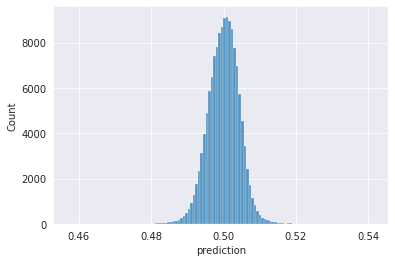


Validation Correlation Score: 0.010507450179763917

Mean Correlation: 0.0108
Median Correlation: 0.0120
Standard Deviation: 0.0302

Mean Pseudo-Sharpe: 0.3591
Median Pseudo-Sharpe: 0.3984
Max Drawdown: -0.0511

Hit Rate (% positive eras): 67.86%


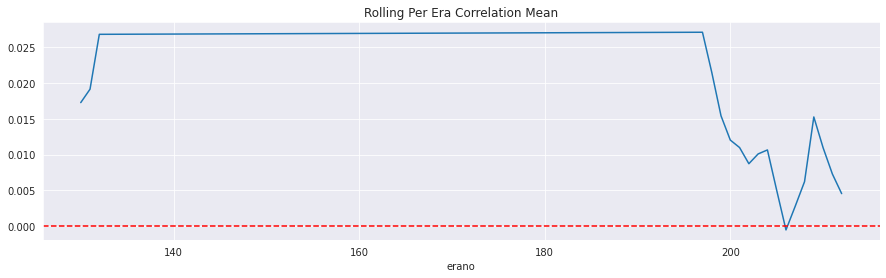

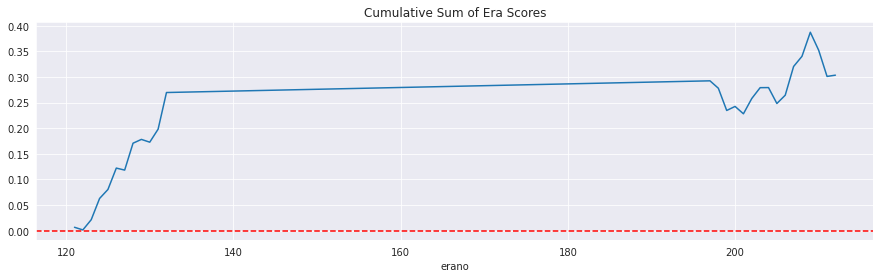

In [35]:
# Check distribution of predictions

pca_validation = pca.transform(valid_df[features]) # PCA transform validation data
valid_df['prediction'] = xgb_bestparams.predict(pca_validation)
print('Validation Scores')
print('Correlation Score: ', correlation_score(valid_df[target], valid_df['prediction']))

print(valid_df['prediction'].describe().round(3))
print()
sns.histplot(valid_df['prediction'], bins=120)
plt.show()
print()

print("Validation Correlation Score:", correlation_score(valid_df['target'], valid_df['prediction']))
print()
mean_valid_era_scores = valid_df.groupby(valid_df['erano']).apply(score, prediction='prediction')
run_analytics(mean_valid_era_scores)

The model clearly overfits the training data because the numerai and correlation scores of the testing and validation sets drop off significantly from the training set scores. This means that the model will most likely not generalize well to the live tournament data. This model might perform well in a couple of rounds, but over time I predict it will generally underperform. 

Personally, the best models I have made that are performing well on the live tournament typically have validation scores between 0.03-0.05 and slightly overfit the training data. 

### Predicting the Live Tournament Data
* Recall we read in the tournament data at the beginning of the notebook under tourney_df
* Make sure the format is correct (id, prediction)

In [36]:
# Apply autoencoder for dimensionality reduction to the tournament data
pca_tourney = pca.transform(tourney_df[features])

# Use our best xgboost model from bayesian optimization to predict autoencoded tournament data
# Avoid Colab RAM issues by splitting tourney data into two pieces (Usually there are about ~1.5m tournament observations to predict)
tourney_preds_1 = xgb_bestparams.predict(pca_tourney[:1000000])
tourney_preds_2 = xgb_bestparams.predict(pca_tourney[1000000:])
tourney_preds = np.concatenate((tourney_preds_1, tourney_preds_2))

df = pd.DataFrame()
df['id'] = tourney_ids
df['prediction'] = tourney_preds
print("Current round: ", current_round)
df.info()

Current round:  282
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1816971 entries, 0 to 1816970
Data columns (total 2 columns):
 #   Column      Dtype  
---  ------      -----  
 0   id          object 
 1   prediction  float32
dtypes: float32(1), object(1)
memory usage: 20.8+ MB


count    1816971.000
mean           0.500
std            0.004
min            0.453
25%            0.497
50%            0.500
75%            0.503
max            0.547
Name: prediction, dtype: float64



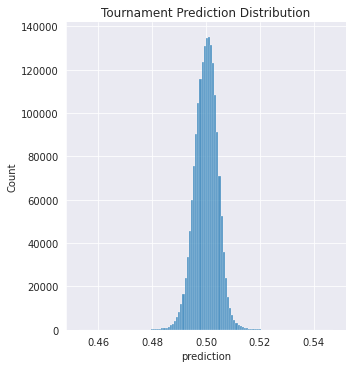

In [41]:
print(df['prediction'].describe().round(3))
print()
sns.displot(df['prediction'], bins=120)
plt.title('Tournament Prediction Distribution')
plt.show()

In [28]:
# Save as csv file you can upload on the numerai website
df.to_csv(f'round{current_round}_pca_xgb_bayesopt_predictions.csv', index=False)

In [29]:
# Alternatively, you can upload the csv directly to Numerai if you don't feel like locally downloading the prediction csv and manually uploading it yourself
# I like using this method because I can submit predictions directly from my phone if I am away from the computer on the weekends

# import numerapi
# napi = numerapi.NumerAPI("public_id", "secret_key")

# # upload predictions
# napi.upload_predictions("predictions.csv", model_id="model_id")

### Documentation and References

Numerapi: https://github.com/numerai/numerapi

Numerai Examples: https://github.com/numerai/example-scripts

Bayesian Optimization: https://github.com/fmfn/BayesianOptimization

XGBoost: https://github.com/dmlc/xgboost/tree/master/demo/guide-python